In [1]:

import numpy as np
import matplotlib.pyplot as plt

import pyomo.environ as pyo
import pyomo.dae as pyodae
import idaes.core.solvers.petsc as petsc  # petsc utilities module
import idaes_examples.mod.dae.petsc.pid_steam_tank as pid
from idaes.core.util.math import smooth_max, smooth_min


In [2]:
?pid

Type:        module
String form: <module 'idaes_examples.mod.dae.petsc.pid_steam_tank' from '/home/bert/miniconda3/envs/idaes/lib/python3.11/site-packages/idaes_examples/mod/dae/petsc/pid_steam_tank.py'>
File:        ~/miniconda3/envs/idaes/lib/python3.11/site-packages/idaes_examples/mod/dae/petsc/pid_steam_tank.py
Docstring:  
Basic PID control test using a tank with steam flowing through it.  The
controller is set up to maintain a tank pressure by adjusting the inlet valve
position.

           valve_1   +----+
  steam ----|><|-->--| ta |    valve_2
                     | nk |-----|><|--->--- steam
                     +----+

In [64]:
m = pid.create_model(
    time_set=[0,1,2,3,4,5,6,7,8,9,10,11, 12],
    nfe=1,
    calc_integ=True,
)
# Modify the model so that that it becomes an optimisation problem, i.e optimise the parameters of the PID controller
m.fs.ctrl.gain_p.unfix()

# Constrain the gain to be between 1e-6 and 1e-4 (example was 1e-5)
m.fs.ctrl.gain_p.setlb(1e-6)
m.fs.ctrl.gain_p.setub(1e-4)


# Optimisation function: gets to setpoint as fast as possible
# minimise the integral of error of m.fs.tank.control_volume.properties_out[12].pressure
# where the error is the difference between the current value and the setpoint (3e5), m.fs.ctrl.setpoint
# and the integral is the sum of the error over the time horizon

m.fs.error = pyo.Var(m.fs.time)
#m.delta_error = pyodae.DerivativeVar(m.error, withrespectto=m.fs.time)
def error_expr(m, t):
   return m.error[t] == (m.ctrl.setpoint[t] - m.tank._pressure_outlet_ref[t])**2
m.fs.error_eq = pyo.Constraint(m.fs.time, rule=error_expr)
# set starting error value to 0
m.fs.error[0].fix(0)
m.fs.objective = pyo.Objective(rule=m.fs.error[12], sense=pyo.minimize) # minimise the total error
# NVM! Turns out that idaes doesn't support petsc optimisation yet :( https://idaes-pse.readthedocs.io/en/2.5.0/reference_guides/core/solvers.html?highlight=petsc#petsc-utilities


number of finite elements specified in apply. The larger number of finite
elements will be used.
2024-06-14 16:20:51 [INFO] idaes.init.fs.valve_1: Initialization Complete: optimal - Optimal Solution Found
2024-06-14 16:20:51 [INFO] idaes.init.fs.tank.control_volume: Initialization Complete
2024-06-14 16:20:52 [INFO] idaes.init.fs.tank: Initialization Complete: optimal - Optimal Solution Found
2024-06-14 16:20:52 [INFO] idaes.init.fs.valve_2: Initialization Complete: optimal - Optimal Solution Found


In [66]:
result = petsc.petsc_dae_by_time_element(
    m,
    time=m.fs.time,
    ts_options={
        "--ts_type": "beuler",
        "--ts_dt": 0.1,
        "--ts_monitor": "",  # set initial step to 0.1
        "--ts_save_trajectory": 1,
    },
)
tj = result.trajectory  # trajectroy data
res = result.results  # solver status list

2024-06-14 16:21:04 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)
2024-06-14 16:21:04 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------
2024-06-14 16:21:04 [INFO] idaes.solve.petsc-dae: DAE: 0
2024-06-14 16:21:04 [INFO] idaes.solve.petsc-dae: Reading nl file: /tmp/tmphd7q0j6l.pyomo.nl
2024-06-14 16:21:04 [INFO] idaes.solve.petsc-dae: Number of constraints: 29
2024-06-14 16:21:04 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 16
2024-06-14 16:21:04 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 13
2024-06-14 16:21:04 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0
2024-06-14 16:21:04 [INFO] idaes.solve.petsc-dae: Number of variables: 29
2024-06-14 16:21:04 [INFO] idaes.solve.petsc-dae: Number of integers: 0
2024-06-14 16:21:04 [INFO] idaes.solve.petsc-dae: Number of binary: 0
2024-06-14 16:21:04 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)
2024-06-14 16:21:04 [INFO] idaes.solve.pe

ApplicationError: Solver (asl) did not exit normally

[1, 0.6965981689455742, 0.6939452449561175, 0.7037955407234134, 0.7057125063856428, 0.7059148963986734, 0.7059282024374596, 0.7059277025815472, 0.7059270633668725, 0.7059268995544904, 0.7059268825163671, 0.7059268873558385, 0.7059268907511644]


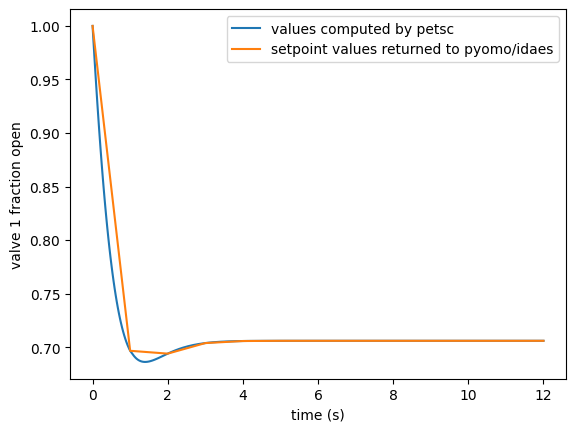

In [35]:
print(list(m.fs.valve_1.valve_opening.get_values().values()))
a = plt.plot(tj.time, tj.get_vec(m.fs.valve_1.valve_opening[12]), label="values computed by petsc")
a = plt.plot(range(0,13),list(m.fs.valve_1.valve_opening.get_values().values()), label="setpoint values returned to pyomo/idaes")
a = plt.ylabel("valve 1 fraction open")
a = plt.xlabel("time (s)")
a = plt.legend()

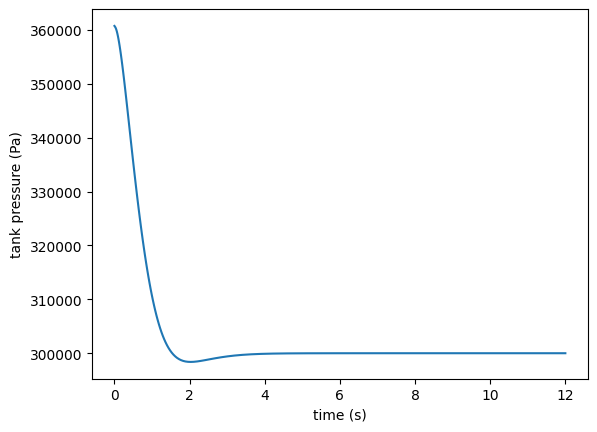

In [6]:
a = plt.plot(tj.time, tj.get_vec(m.fs.tank.control_volume.properties_out[12].pressure))
a = plt.ylabel("tank pressure (Pa)")
a = plt.xlabel("time (s)")

# Model a ramp in inlet pressure

Next we show how to add an explicit time variable and ramp the inlet pressure from 500 kPa to 600 kPa between 10 and 12 seconds.

In [7]:
# Create a new copy of the model that runs to 24 seconds, and add a constraint.

m = pid.create_model(
    time_set=[0, 24],
    nfe=1,
    calc_integ=True,
)
# time_var will be an explicit time variable we can use in constraints.
m.fs.time_var = pyo.Var(m.fs.time)

# We'll add a constraint to calculate the inlet pressure based on time,
# so we need to unfix pressure.
m.fs.valve_1.control_volume.properties_in[0].pressure.unfix()
m.fs.valve_1.control_volume.properties_in[24].pressure.unfix()

# The solver will directly set the time variable for the DAE solve, but
# solving the initial conditions is just a system of nonlinear equations,
# so we need to fix the initial time.
m.fs.time_var[0].fix(m.fs.time.first())

# We could break up the time domain and solve this in pieces, but creative use
# of min and max will let us create the ramping function we want.
# From 10s to 12s ramp inlet pressure from 500,000 Pa to 600,000 Pa
@m.fs.Constraint(m.fs.time)
def inlet_pressure_eqn(b, t):
    return b.valve_1.control_volume.properties_in[t].pressure == smooth_min(
        600000, smooth_max(500000, 50000 * (b.time_var[t] - 10) + 500000)
    )

2024-06-14 12:30:00 [INFO] idaes.init.fs.valve_1: Initialization Complete: optimal - Optimal Solution Found
2024-06-14 12:30:00 [INFO] idaes.init.fs.tank.control_volume: Initialization Complete
2024-06-14 12:30:00 [INFO] idaes.init.fs.tank: Initialization Complete: optimal - Optimal Solution Found
2024-06-14 12:30:00 [INFO] idaes.init.fs.valve_2: Initialization Complete: optimal - Optimal Solution Found


In [8]:
# Solve the new problem.  Notice the new argument specifying the explicit time variable.
result = petsc.petsc_dae_by_time_element(
    m,
    time=m.fs.time,
    timevar=m.fs.time_var,
    ts_options={
        "--ts_type": "beuler",
        "--ts_dt": 0.1,
        "--ts_monitor": "",  # set initial step to 0.1
        "--ts_save_trajectory": 1,
    },
)
tj = result.trajectory  # trajectroy data
res = result.results  # solver status list

2024-06-14 12:30:00 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)
2024-06-14 12:30:00 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------
2024-06-14 12:30:00 [INFO] idaes.solve.petsc-dae: DAE: 0
2024-06-14 12:30:00 [INFO] idaes.solve.petsc-dae: Reading nl file: /tmp/tmpe3zv0yyo.pyomo.nl
2024-06-14 12:30:00 [INFO] idaes.solve.petsc-dae: Number of constraints: 29
2024-06-14 12:30:00 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 15
2024-06-14 12:30:00 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 14
2024-06-14 12:30:00 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0
2024-06-14 12:30:00 [INFO] idaes.solve.petsc-dae: Number of variables: 29
2024-06-14 12:30:00 [INFO] idaes.solve.petsc-dae: Number of integers: 0
2024-06-14 12:30:00 [INFO] idaes.solve.petsc-dae: Number of binary: 0
2024-06-14 12:30:00 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)
2024-06-14 12:30:00 [INFO] idaes.solve.pe

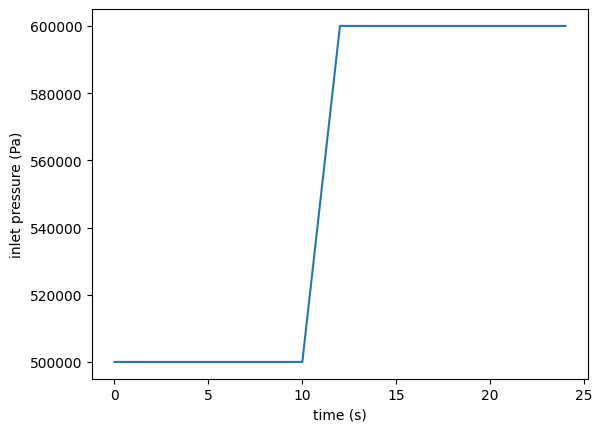

In [9]:
a = plt.plot(
    tj.time, tj.get_vec(m.fs.valve_1.control_volume.properties_in[24].pressure)
)
a = plt.ylabel("inlet pressure (Pa)")
a = plt.xlabel("time (s)")

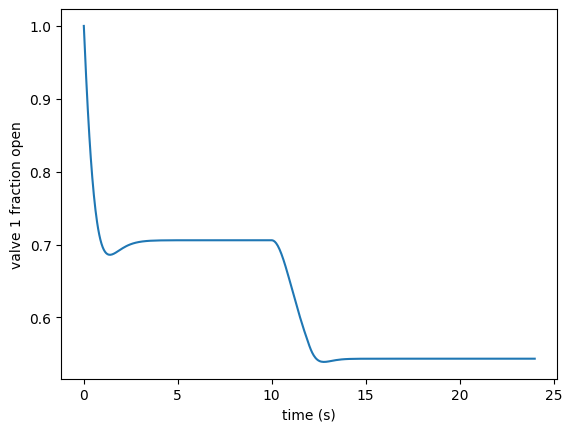

In [10]:
a = plt.plot(tj.time, tj.get_vec(m.fs.valve_1.valve_opening[24]))
a = plt.ylabel("valve 1 fraction open")
a = plt.xlabel("time (s)")

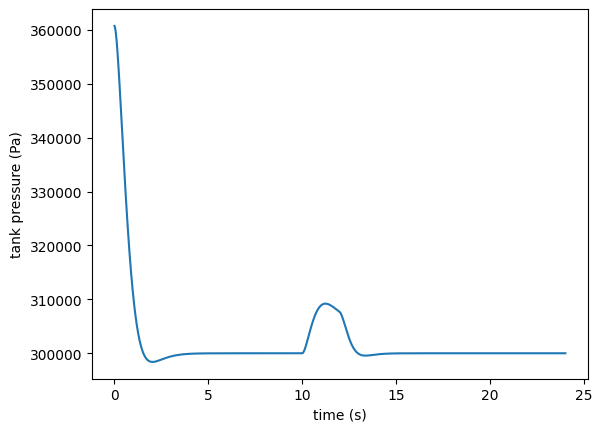

In [11]:
a = plt.plot(tj.time, tj.get_vec(m.fs.tank.control_volume.properties_out[24].pressure))
a = plt.ylabel("tank pressure (Pa)")
a = plt.xlabel("time (s)")

# Model a ramp in inlet pressure (again)
Here we repeat the ramp from the previous simulation in a different way. In this case we do the integration in three parts. 1) Constant pressure at 500 kPa to 10 s 2) ramp from 500 to 600 kPa from 10 to 12 s. 3) Constant pressure at 600 kPa from 12 to 24 s.

In [12]:
# Create a new copy of the model that runs to 24 seconds, and add a constraint.

m = pid.create_model(
    time_set=[0, 10, 12, 24],
    nfe=3,
    calc_integ=True,
)
# time_var will be an explicit time variable we can use in constraints.
m.fs.time_var = pyo.Var(m.fs.time)

# We'll add a constraint to calculate the inlet pressure from 10 to 12s.  The rest of the
# time pressure will be fixed. For the time section from 10 to 12s, the constraints are
# defined by time 12; this means the pressure at time 12 should be unfixed and the
# pressure constraint should be active.  At all other times, pressure should be fixed and
# the pressure constraint should be deactivated.
m.fs.valve_1.control_volume.properties_in[0].pressure.fix(500000)
m.fs.valve_1.control_volume.properties_in[10].pressure.fix(500000)
m.fs.valve_1.control_volume.properties_in[12].pressure.set_value(600000)
m.fs.valve_1.control_volume.properties_in[12].pressure.unfix()
m.fs.valve_1.control_volume.properties_in[24].pressure.fix(600000)


@m.fs.Constraint(m.fs.time)
def inlet_pressure_eqn(b, t):
    return (
        b.valve_1.control_volume.properties_in[t].pressure
        == 50000 * (b.time_var[t] - 10) + 500000
    )


m.fs.inlet_pressure_eqn.deactivate()
m.fs.inlet_pressure_eqn[12].activate()

2024-06-14 12:30:13 [INFO] idaes.init.fs.valve_1: Initialization Complete: optimal - Optimal Solution Found
2024-06-14 12:30:13 [INFO] idaes.init.fs.tank.control_volume: Initialization Complete
2024-06-14 12:30:13 [INFO] idaes.init.fs.tank: Initialization Complete: optimal - Optimal Solution Found
2024-06-14 12:30:13 [INFO] idaes.init.fs.valve_2: Initialization Complete: optimal - Optimal Solution Found


In [13]:
# Solve the new problem.  Notice the argument specifying the explicit time variable.
result = petsc.petsc_dae_by_time_element(
    m,
    time=m.fs.time,
    timevar=m.fs.time_var,
    ts_options={
        "--ts_type": "beuler",
        "--ts_dt": 0.1,
        "--ts_monitor": "",  # set initial step to 0.1
        "--ts_save_trajectory": 1,
    },
)
tj = result.trajectory  # trajectroy data
res = result.results  # solver status list

2024-06-14 12:30:13 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)
2024-06-14 12:30:13 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------
2024-06-14 12:30:13 [INFO] idaes.solve.petsc-dae: DAE: 0
2024-06-14 12:30:13 [INFO] idaes.solve.petsc-dae: Reading nl file: /tmp/tmptbt5tawu.pyomo.nl
2024-06-14 12:30:13 [INFO] idaes.solve.petsc-dae: Number of constraints: 28
2024-06-14 12:30:13 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 14
2024-06-14 12:30:13 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 14
2024-06-14 12:30:13 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0
2024-06-14 12:30:13 [INFO] idaes.solve.petsc-dae: Number of variables: 28
2024-06-14 12:30:13 [INFO] idaes.solve.petsc-dae: Number of integers: 0
2024-06-14 12:30:13 [INFO] idaes.solve.petsc-dae: Number of binary: 0
2024-06-14 12:30:13 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)
2024-06-14 12:30:13 [INFO] idaes.solve.pe

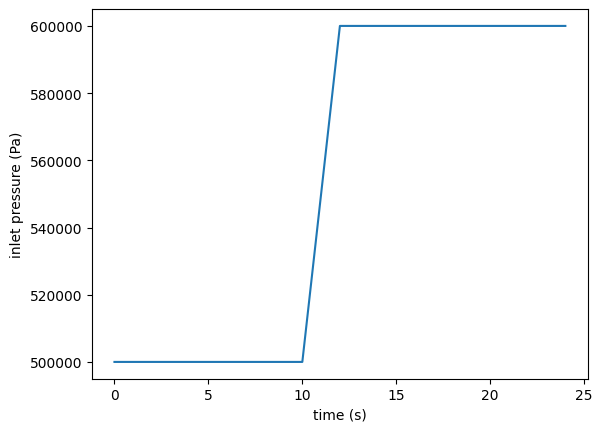

In [14]:
a = plt.plot(
    tj.time, tj.get_vec(m.fs.valve_1.control_volume.properties_in[24].pressure)
)
a = plt.ylabel("inlet pressure (Pa)")
a = plt.xlabel("time (s)")

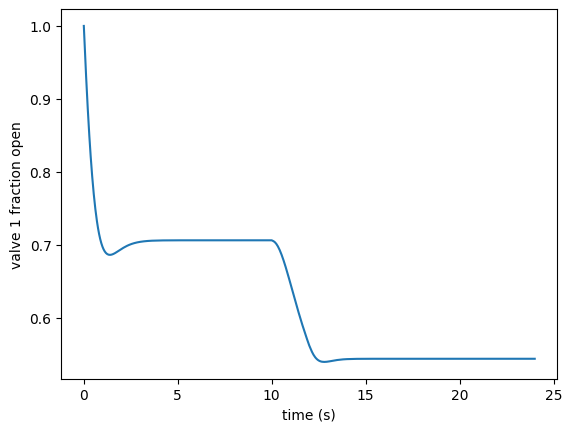

In [15]:
a = plt.plot(tj.time, tj.get_vec(m.fs.valve_1.valve_opening[24]))
a = plt.ylabel("valve 1 fraction open")
a = plt.xlabel("time (s)")

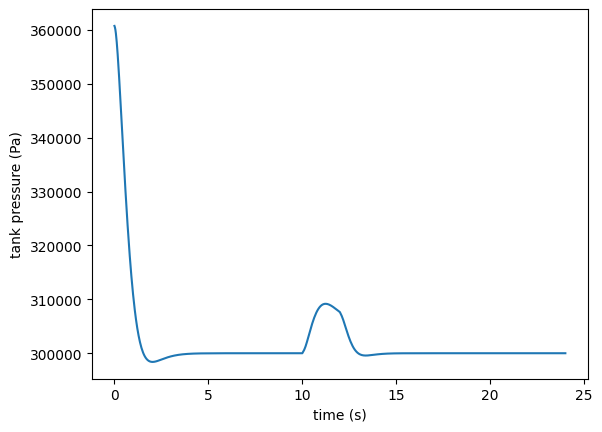

In [16]:
a = plt.plot(tj.time, tj.get_vec(m.fs.tank.control_volume.properties_out[24].pressure))
a = plt.ylabel("tank pressure (Pa)")
a = plt.xlabel("time (s)")

In [17]:
from idaes.apps.caprese.nmpc import NMPCSim